In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set visual style
plt.style.use('ggplot')

# ==========================================
# 1. THE DATA LAYER (Synthetic "Ground Truth")
# ==========================================
# We simulate a scenario where we have detailed data for 10,000 buildings
# (The "Training Set") to teach the AI.

def generate_training_data(n=10000):
    np.random.seed(42)
    data = []

    for i in range(n):
        # Feature: Building Metadata
        b_type = np.random.choice(['Office', 'Residential', 'Education', 'Healthcare']) # Building type
        gfa = np.random.randint(1000, 50000) # Square meters
        floors = np.random.randint(1, 40) # Num of floors
        year = np.random.randint(1980, 2025)
        structure_type = np.random.choice(['Steel', 'Concrete', 'Timber', 'Mixed'])

        # Physics-based Logic (The "Real" Calc)
        # We add noise/complexity so the ML has something to learn
        base_intensity = 0
        if structure_type == 'Concrete': base_intensity = 450 # kgCO2e/m2
        elif structure_type == 'Steel': base_intensity = 550 # kgCO2e/m2
        elif structure_type == 'Timber': base_intensity = 180 # kgCO2e/m2
        elif structure_type == 'Mixed': base_intensity = 350 # kgCO2e/m2

        # Adjusters
        height_penalty = floors * 5 # Taller buildings need more structure per m2
        type_adjuster = 1.2 if b_type == 'Healthcare' else 1.0 # (More MEP intensity)

        # Final "Ground Truth" Intensity with random variance (noise)
        real_intensity = (base_intensity + height_penalty) * type_adjuster * np.random.uniform(0.9, 1.1)
        total_carbon = (real_intensity * gfa) / 1000 # tCO2e

        data.append({
            'GFA_sqm': gfa,
            'Building_Type': b_type,
            'Num_Floors': floors,
            'Year_Built': year,
            'Structure_Type': structure_type,
            'Actual_Scope3_tCO2e': total_carbon, # Target Variable
            'Intensity_kgCO2e_m2': real_intensity
        })

    return pd.DataFrame(data)

df_train = generate_training_data(10000)

print("Training Data Sample (High Fidelity):")
print(df_train.head(10))

Training Data Sample (High Fidelity):
   GFA_sqm Building_Type  Num_Floors  Year_Built Structure_Type  \
0    16795     Education          29        1994         Timber   
1     7265        Office          19        2002         Timber   
2    45131        Office          24        1982       Concrete   
3     3433    Healthcare          21        2012          Mixed   
4    28480        Office          27        2021          Mixed   
5     1189    Healthcare           3        2016         Timber   
6    15502        Office          18        1983          Steel   
7    44001   Residential           9        2005          Steel   
8    24483    Healthcare           7        2023          Steel   
9    15541     Education          17        2015       Concrete   

   Actual_Scope3_tCO2e  Intensity_kgCO2e_m2  
0          5763.706673           343.179915  
1          1981.591876           272.758689  
2         23442.436851           519.430920  
3          1916.274939           558.192

In [ ]:
# # ==========================================
# 1a. STORING THE DATA (Optional)
# ==========================================
# Objective: Save the generated training data to a CSV file for future use.

# df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/SideProject-Scope3Analytics/df_train-new.csv', index=False)
# print("df_train-new.csv has been saved to the current directory.")

In [ ]:
# ==========================================
# 2. THE AI MODEL (The "Estimator")
# ==========================================
# Objective: Predict 'Actual_Scope3_tCO2e' using only basic metadata.
# We will use a Random Forest Regressor for this task.

# A. Preprocessing
# One-hot encode categorical variables
df_ml = pd.get_dummies(df_train, columns=['Building_Type', 'Structure_Type'], drop_first=True)

# Features (X) vs Target (y)
# For features (X), we exclude 'Actual_Scope3_tCO2e' and 'Intensity_kgCO2e_m2' (the latter is derived)
# For target (y), we use 'Actual_Scope3_tCO2e'
X = df_ml.drop(['Actual_Scope3_tCO2e', 'Intensity_kgCO2e_m2'], axis=1)
y = df_ml['Actual_Scope3_tCO2e']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# B. Model Training (Random Forest)
# We use RF because it handles non-linear relationships (like height penalties) well
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# C. Evaluation
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\n--- Model Performance ---")
print(f"R² Score: {r2:.3f} (Model explains {r2*100:.1f}% of variance)")
print(f"Mean Absolute Error: {mae:.2f} tCO2e")
print("Interpretation: The AI can estimate carbon footprint with high accuracy using just basic building stats.")


--- Model Performance ---
R² Score: 0.987 (Model explains 98.7% of variance)
Mean Absolute Error: 680.04 tCO2e
Interpretation: The AI can estimate carbon footprint with high accuracy using just basic building stats.


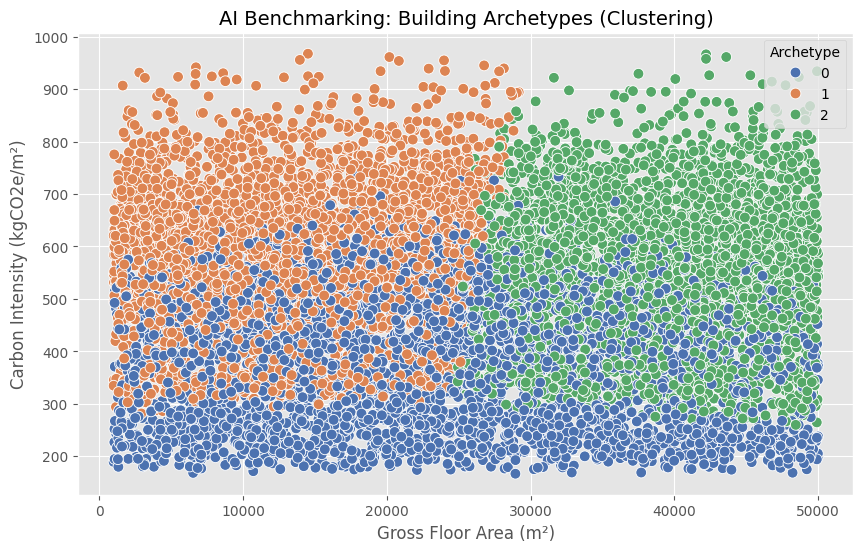

In [ ]:
# ==========================================
# 3. UNSUPERVISED LEARNING (Clustering)
# ==========================================
# Objective: Group buildings to find "Archetypes" for benchmarking.

# Scale data for clustering
scaler = StandardScaler()
features_for_clustering = df_train[['GFA_sqm', 'Num_Floors', 'Intensity_kgCO2e_m2']]
X_scaled = scaler.fit_transform(features_for_clustering)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_train['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='GFA_sqm', y='Intensity_kgCO2e_m2', hue='Cluster', palette='deep', s=60)
plt.title('AI Benchmarking: Building Archetypes (Clustering)', fontsize=14)
plt.xlabel('Gross Floor Area (m²)')
plt.ylabel('Carbon Intensity (kgCO2e/m²)')
plt.legend(title='Archetype')
plt.show()

In [ ]:
# ==========================================
# 4. MVP FEATURE: The "Missing Data" Audit
# ==========================================
# Simulation: Client uploads a CSV of buildings with NO carbon data.
# We use our model to fill the gaps.

new_buildings = pd.DataFrame([
    {'GFA_sqm': 12000, 'Building_Type': 'Office', 'Num_Floors': 8, 'Year_Built': 2005, 'Structure_Type': 'Concrete'},
    {'GFA_sqm': 45000, 'Building_Type': 'Healthcare', 'Num_Floors': 12, 'Year_Built': 1998, 'Structure_Type': 'Steel'},
    {'GFA_sqm': 2500,  'Building_Type': 'Residential', 'Num_Floors': 3, 'Year_Built': 2020, 'Structure_Type': 'Timber'}
])

# Process input similar to training data
new_buildings_encoded = pd.get_dummies(new_buildings, columns=['Building_Type', 'Structure_Type'])
# Align columns with training set (add missing columns with 0)
for col in X.columns:
    if col not in new_buildings_encoded.columns:
        new_buildings_encoded[col] = 0
new_buildings_encoded = new_buildings_encoded[X.columns]

# Predict
new_buildings['Predicted_Scope3_tCO2e'] = model.predict(new_buildings_encoded)

# Generate Text Report
print("\n--- AI Scope 3 Audit Report ---")
for index, row in new_buildings.iterrows():
    intensity_kg_m2 = (row['Predicted_Scope3_tCO2e'] * 1000) / row['GFA_sqm']
    status = "High" if intensity_kg_m2 > avg_intensity_ref else "Efficient"
    diff_pct = (intensity_kg_m2 - avg_intensity_ref) / avg_intensity_ref * 100

    print(f"Building #{index+1} ({row['Building_Type']}):")
    print(f"  • Size: {row['GFA_sqm']} m²")
    print(f"  • Structure: {row['Structure_Type']}")
    print(f"  • AI Estimated Upstream Carbon: {row['Predicted_Scope3_tCO2e']:,.0f} tCO2e")
    print(f"  • Estimated Intensity: {intensity_kg_m2:.1f} kgCO2e/m² (Portfolio avg: {avg_intensity_ref:.1f} kgCO2e/m², {diff_pct:+.1f}%)")
    print(f"  • Benchmarking: This asset is rated '{status}' relative to portfolio avg.")
    print("-" * 40)



--- AI Scope 3 Audit Report ---
Building #1 (Office):
  • Size: 12000 m²
  • Structure: Concrete
  • AI Estimated Upstream Carbon: 5,921 tCO2e
  • Estimated Intensity: 493.4 kgCO2e/m² (Portfolio avg: 506.9 kgCO2e/m², -2.7%)
  • Benchmarking: This asset is rated 'Efficient' relative to portfolio avg.
----------------------------------------
Building #2 (Healthcare):
  • Size: 45000 m²
  • Structure: Steel
  • AI Estimated Upstream Carbon: 32,300 tCO2e
  • Estimated Intensity: 717.8 kgCO2e/m² (Portfolio avg: 506.9 kgCO2e/m², +41.6%)
  • Benchmarking: This asset is rated 'High' relative to portfolio avg.
----------------------------------------
Building #3 (Residential):
  • Size: 2500 m²
  • Structure: Timber
  • AI Estimated Upstream Carbon: 579 tCO2e
  • Estimated Intensity: 231.6 kgCO2e/m² (Portfolio avg: 506.9 kgCO2e/m², -54.3%)
  • Benchmarking: This asset is rated 'Efficient' relative to portfolio avg.
----------------------------------------



--- SCENARIO REPORT: Retrofit Simulation ---
Building: Healthcare Center (ID #1)
Scenario: Switch Structure from [Steel] to [Timber]
------------------------------------------------
Baseline Emissions:   32,300 tCO2e
Optimized Emissions:  12,762 tCO2e
------------------------------------------------
NET SAVINGS:          19,538 tCO2e (-60.5%)


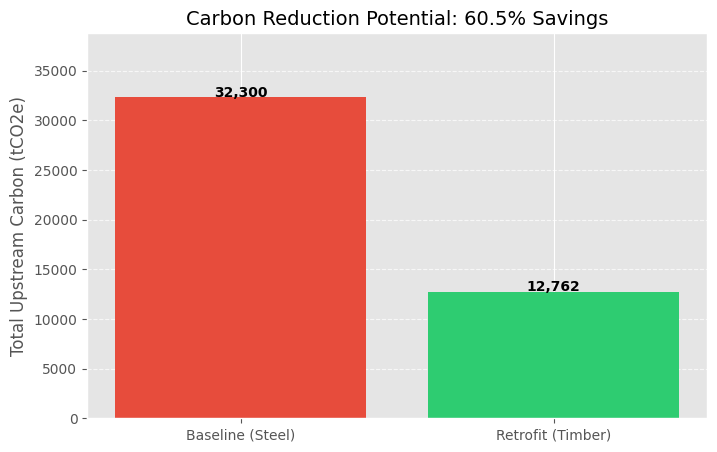


Business Insight for FM:
> "By prioritizing low-carbon materials for this asset, you can offset the annual operational carbon of ~3907 typical homes."


In [ ]:
# ==========================================
# 5. MVP FEATURE: The "What-If" Scenario Optimizer
# ==========================================
# Objective: meaningful interactivity. Allow users to test retrofits.

def run_scenario_simulation(building_index, retrofit_structure, current_buildings_df, model, encoder_cols):
    """
    Simulates a change in material/structure and predicts the new carbon footprint.
    """
    # 1. Copy the target building data so we don't mess up the original
    target_building = current_buildings_df.iloc[[building_index]].copy()
    
    # 2. Capture the 'Before' state
    original_structure = target_building['Structure_Type'].values[0]
    # Re-predict 'Before' to ensure apples-to-apples comparison using the same model
    # (We need to encode it exactly like the training data)
    input_before = pd.get_dummies(target_building, columns=['Building_Type', 'Structure_Type'])
    # Add missing columns
    for col in encoder_cols:
        if col not in input_before.columns:
            input_before[col] = 0
    input_before = input_before[encoder_cols]
    
    pred_before = model.predict(input_before)[0]
    
    # 3. Apply the 'After' state (The Retrofit)
    target_building['Structure_Type'] = retrofit_structure
    
    # Encode the new state
    input_after = pd.get_dummies(target_building, columns=['Building_Type', 'Structure_Type'])
    for col in encoder_cols:
        if col not in input_after.columns:
            input_after[col] = 0
    input_after = input_after[encoder_cols]
    
    # 4. Predict
    pred_after = model.predict(input_after)[0]
    
    # 5. Calculate Savings
    savings = pred_before - pred_after
    pct_savings = (savings / pred_before) * 100
    
    return original_structure, pred_before, pred_after, savings, pct_savings

# --- EXECUTING THE SCENARIO ---

# Let's pick Building #1 (Index 1) from our 'new_buildings' list created in Part 4.
# It is currently 'Steel' (see the previous code block setup).
# We want to see what happens if we built it with 'Timber' instead.

target_idx = 1 # The Healthcare building / Building #2
retrofit_material = 'Timber'

orig_mat, val_before, val_after, saved_carbon, saved_pct = run_scenario_simulation(
    target_idx, 
    retrofit_material, 
    new_buildings, 
    model, 
    X.columns # Passing the column structure from the training set
)

# --- VISUALIZING THE BUSINESS CASE ---

print(f"\n--- SCENARIO REPORT: Retrofit Simulation ---")
print(f"Building: Healthcare Center (ID #{target_idx})")
print(f"Scenario: Switch Structure from [{orig_mat}] to [{retrofit_material}]")
print(f"------------------------------------------------")
print(f"Baseline Emissions:   {val_before:,.0f} tCO2e")
print(f"Optimized Emissions:  {val_after:,.0f} tCO2e")
print(f"------------------------------------------------")
print(f"NET SAVINGS:          {saved_carbon:,.0f} tCO2e (-{saved_pct:.1f}%)")

# Visualization
scenario_data = pd.DataFrame({
    'Scenario': ['Baseline (Steel)', 'Retrofit (Timber)'],
    'Emissions (tCO2e)': [val_before, val_after]
})

plt.figure(figsize=(8, 5))
bars = plt.bar(scenario_data['Scenario'], scenario_data['Emissions (tCO2e)'], color=['#e74c3c', '#2ecc71'])

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f"{yval:,.0f}", ha='center', fontweight='bold')

plt.title(f'Carbon Reduction Potential: {saved_pct:.1f}% Savings', fontsize=14)
plt.ylabel('Total Upstream Carbon (tCO2e)')
plt.ylim(0, max(val_before, val_after) * 1.2) # Add headroom for text
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nBusiness Insight for FM:")
print(f"> \"By prioritizing low-carbon materials for this asset, you can offset the annual operational carbon of ~{int(saved_carbon/5)} typical homes.\"")


--- COMPARATIVE SCENARIO RESULTS ---
Retrofit_To Original_Structure  Baseline_tCO2e  Retrofit_tCO2e  Absolute_Savings_tCO2e  Pct_Savings
     Timber              Steel    32300.197092    12762.101691            19538.095401    60.489090
      Mixed              Steel    32300.197092    21376.907159            10923.289933    33.818029
   Concrete              Steel    32300.197092    26431.820415             5868.376677    18.168238
      Steel              Steel    32300.197092    32300.197092                0.000000     0.000000


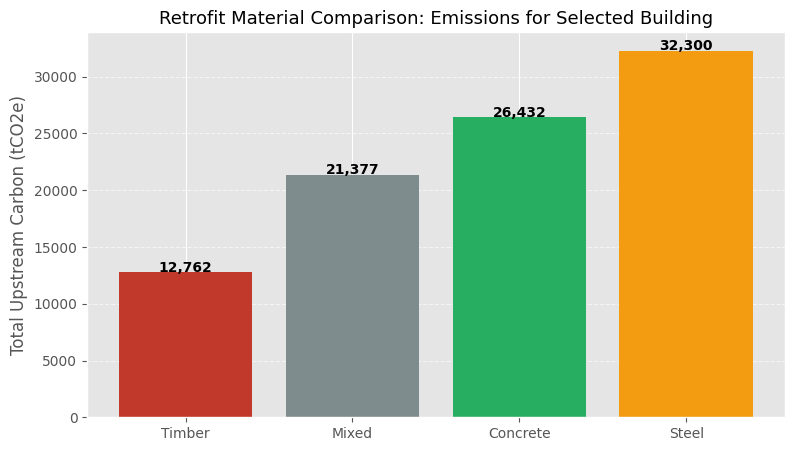


Top Material Recommendation: Timber (Estimated 60.5% reduction vs baseline)
Detailed results above can be used to prioritize materials by carbon impact for this asset.


In [17]:
# --- ADDITIONAL SCENARIOS: Test other structure types for the same building ---
materials = ['Steel', 'Concrete', 'Timber', 'Mixed']

results = []
for mat in materials:
    orig, before, after, saved, pct = run_scenario_simulation(
        target_idx,
        mat,
        new_buildings,
        model,
        X.columns
    )
    results.append({
        'Retrofit_To': mat,
        'Original_Structure': orig,
        'Baseline_tCO2e': before,
        'Retrofit_tCO2e': after,
        'Absolute_Savings_tCO2e': saved,
        'Pct_Savings': pct
    })

scenario_df = pd.DataFrame(results).sort_values('Retrofit_tCO2e')
print('\n--- COMPARATIVE SCENARIO RESULTS ---')
print(scenario_df.to_string(index=False))

# Visual summary
plt.figure(figsize=(9,5))
bars = plt.bar(scenario_df['Retrofit_To'], scenario_df['Retrofit_tCO2e'], color=['#c0392b','#7f8c8d','#27ae60','#f39c12'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 30, f"{yval:,.0f}", ha='center', fontweight='bold')
plt.title('Retrofit Material Comparison: Emissions for Selected Building', fontsize=13)
plt.ylabel('Total Upstream Carbon (tCO2e)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Quick business insight derived from the table
best = scenario_df.loc[scenario_df['Retrofit_tCO2e'].idxmin()]
print(f"\nTop Material Recommendation: {best['Retrofit_To']} (Estimated {best['Pct_Savings']:.1f}% reduction vs baseline)")
print("Detailed results above can be used to prioritize materials by carbon impact for this asset.")

## Recommendations & Business Insights

- **Prioritize low-embodied-carbon materials:** For this Healthcare asset, `Timber` shows the largest estimated upstream carbon reduction. Favor low-carbon materials where structural and code constraints allow.
- **Asset-level prioritization:** Use per-asset scenario outputs (the table above) to rank retrofit opportunities across the portfolio by absolute tCO2e saved and % savings.
- **Combine with operational measures:** Embodied carbon savings from retrofits compound when paired with operational energy reductions (e.g., HVAC upgrades).
- **Pilot before scale:** Run a pilot retrofit on a representative archetype to validate costs, constructability, and actual emissions before portfolio-wide roll-out.

## Retrofit Trade-offs and Material Selection Considerations

- **Cost vs Carbon:** Lower-embodied-carbon materials (e.g., engineered timber) may have higher upfront costs or require specialized contractors; weigh CapEx against lifetime carbon savings and potential incentives.
- **Structural constraints & code:** Some materials limit maximum height or span and may need hybrid designs (e.g., concrete cores with timber frames) which affect savings.
- **Fire, acoustic, and durability requirements:** Especially for healthcare and high-occupancy buildings, stricter performance specs can restrict material choices or add treatments that increase embodied carbon.
- **Maintenance and lifecycle impacts:** Materials with lower embodied carbon might require different maintenance regimes; include replacement cycles in lifecycle assessments.
- **Availability & supply chain emissions:** Local availability reduces transport emissions and procurement risk; global supply bottlenecks can delay projects.
- **Circularity and end-of-life:** Prefer materials that are recyclable, reusable, or biodegradable to avoid transferring emissions to demolition and waste stages.
- **Operational trade-offs:** Some retrofits (e.g., lighter timber structures) can change thermal mass and acoustic behaviour, with implications for HVAC energy and occupant comfort.

Use the scenario outputs to create a shortlist balancing carbon, cost, constructability, and performance. For procurement, request EPDs (Environmental Product Declarations) to validate supplier claims and incorporate them into the model for higher-fidelity results.